## Training modules overview

In [ ]:
from fastai.basic_train import *
from fastai.gen_doc.nbdoc import *
from fastai.callbacks import *

The fastai library structures its training process around the [`Learner`](/basic_train.html#Learner) class, whose object binds together a PyTorch model, a dataset, an optimizer, and a loss function; the entire learner object then will allow us to launch training.

[`basic_train`](/basic_train.html#basic_train) defines this [`Learner`](/basic_train.html#Learner) class, along with the wrapper around the PyTorch optimizer that the library uses. It defines the basic training loop that is used each time you call the [`fit`](/basic_train.html#fit) method (or one of its variants) in fastai. This training loop is very bare-bones and has very few lines of codes; you can customize it by supplying an optional [`Callback`](/callback.html#Callback) argument to the [`fit`](/basic_train.html#fit) method.

[`callback`](/callback.html#callback) defines the [`Callback`](/callback.html#Callback) class and the [`CallbackHandler`](/callback.html#CallbackHandler) class that is responsible for the communication between the training loop and the [`Callback`](/callback.html#Callback)'s methods. The [`CallbackHandler`](/callback.html#CallbackHandler) maintains a state dictionary able to provide each [`Callback`](/callback.html#Callback) object all the information of the training loop it belongs to, putting any imaginable tweaks of the training loop within your reach.

[`callbacks`](/callbacks.html#callbacks) implements each predefined [`Callback`](/callback.html#Callback) class of the fastai library in a separate module. Some modules deal with scheduling the hyperparameters, like [`callbacks.one_cycle`](/callbacks.one_cycle.html#callbacks.one_cycle), [`callbacks.lr_finder`](/callbacks.lr_finder.html#callbacks.lr_finder) and [`callback.general_sched`](/callbacks.general_sched.html#callbacks.general_sched). Others allow special kinds of training like [`callbacks.fp16`](/callbacks.fp16.html#callbacks.fp16) (mixed precision) and [`callbacks.rnn`](/callbacks.rnn.html#callbacks.rnn). The [`Recorder`](/basic_train.html#Recorder) and [`callbacks.hooks`](/callbacks.hooks.html#callbacks.hooks) are useful to save some internal data generated in the training loop.

[`train`](/train.html#train) then uses these callbacks to implement useful helper functions. Lastly, [`metrics`](/metrics.html#metrics) contains all the functions and classes you might want to use to evaluate your training results; simpler metrics are implemented as functions while more complicated ones as subclasses of [`Callback`](/callback.html#Callback). For more details on implementing metrics as [`Callback`](/callback.html#Callback), please refer to [creating your own metrics](/metrics.html#Creating-your-own-metric).

## Walk-through of key functionalities

We'll do a quick overview of the key pieces of fastai's training modules. See the separate module docs for details on each. 

### Setup
Import required [modules](/index.html#imports) and prepare [data](/basic_data.html#Get-your-data-ready-for-training): 

In [ ]:
from fastai.vision import *

path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)

*`URLs.MNIST_SAMPLE` is a small subset of the classic MNIST dataset containing the images of just 3's and 7's for the purpose of demo and documentation here. Common [`datasets`](/datasets.html#datasets) can be downloaded with [`untar_data`](/datasets.html#untar_data) - which we will use to create an [`ImageDataBunch`](/vision.data.html#ImageDataBunch) object*

### Basic training with [`Learner`](/basic_train.html#Learner)

We can create a minimal CNN using [`simple_cnn`](/layers.html#simple_cnn) (see [`models`](/vision.models.html#vision.models) for details on creating models):

In [ ]:
model = simple_cnn((3,16,16,2))

The [`Learner`](/basic_train.html#Learner) class plays a central role in training models; when you create a [`Learner`](/basic_train.html#Learner) you need to specify at the very minimum the [`data`](/vision.data.html#vision.data) and `model` to use.

In [ ]:
learn = Learner(data, model)

These are enough to create a [`Learner`](/basic_train.html#Learner) object and then use it to train a model using its [`fit`](/basic_train.html#fit) method. If you have a CUDA-enabled GPU, it will be used automatically. To call the [`fit`](/basic_train.html#fit) method, you have to at least specify how many epochs to train for.

In [ ]:
learn.fit(1)

### Viewing metrics

To see how our training is going, we can request that it reports various kinds of [`metrics`](/metrics.html#metrics) after each epoch. You can pass it to the constructor, or set it later. Note that metrics are always calculated on the validation set.

In [ ]:
learn.metrics=[accuracy]
learn.fit(1)

### Extending training with callbacks

You can use [`callback`](/callback.html#callback)s to modify training in almost any way you can imagine. For instance, we've provided a callback to implement Leslie Smith's 1cycle training method.

In [ ]:
cb = OneCycleScheduler(learn, lr_max=0.01)
learn.fit(1, callbacks=cb)

The [`Recorder`](/basic_train.html#Recorder) callback is automatically added for you, and you can use it to see what happened in your training, e.g.:

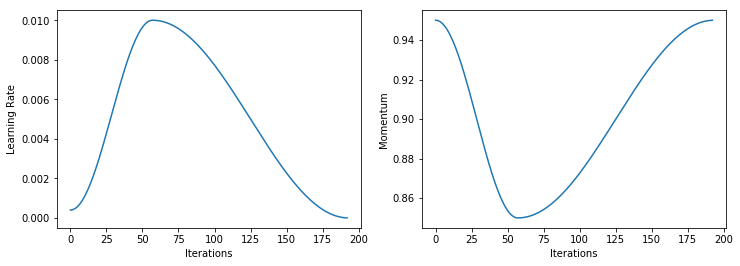

In [ ]:
learn.recorder.plot_lr(show_moms=True)

### Extending [`Learner`](/basic_train.html#Learner) with [`train`](/train.html#train)

Many of the callbacks can be used more easily by taking advantage of the [`Learner`](/basic_train.html#Learner) extensions in [`train`](/train.html#train). For instance, instead of creating OneCycleScheduler manually as above, you can simply call [`Learner.fit_one_cycle`](/train.html#fit_one_cycle):

In [ ]:
learn.fit_one_cycle(1)

### Applications

Note that if you're training a model for one of our supported *applications*, there's a lot of help available to you in the application modules:

- [`vision`](/vision.html#vision)
- [`text`](/text.html#text)
- [`tabular`](/tabular.html#tabular)
- [`collab`](/collab.html#collab)

For instance, let's use [`cnn_learner`](/vision.learner.html#cnn_learner) (from [`vision`](/vision.html#vision)) to quickly fine-tune a pre-trained Imagenet model for MNIST (not a very practical approach, of course, since MNIST is handwriting and our model is pre-trained on photos!).

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(1)